In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [5]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

True

In [6]:
%autoreload

data, test_data = mre_pinn.data.load_bioqic_dataset('../data/BIOQIC', data_name='fem_box', frequency=80, xyz_slice='2D')
data

Loading ../data/BIOQIC/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
Loading ../data/BIOQIC/fem_box_elastogram.npy
     <class 'numpy.ndarray'> (6, 10, 80, 100) complex128
Loading ../data/BIOQIC/fem_box_regions.npy
     <class 'numpy.ndarray'> (10, 80, 100) int64
Single frequency 2D
<xarray.Dataset>
Dimensions:         (frequency: 1, x: 80, y: 100, component: 2)
Coordinates:
  * frequency       (frequency) float64 80.0
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y               (y) float64 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
    z               float64 0.0
  * component       (component) <U1 'z' 'y'
Data variables:
    u               (frequency, x, y, component) complex128 (-4.2190458277627...
    mu              (frequency, x, y) complex128 (3000+502.6548245743669j) .....
    spatial_region  (x, y) int64 

<xarray.Dataset>
Dimensions:         (frequency: 1, x: 80, y: 100, component: 2)
Coordinates:
  * frequency       (frequency) float64 80.0
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
  * y               (y) float64 0.0 0.001 0.002 0.003 ... 0.097 0.098 0.099
    z               float64 0.0
  * component       (component) <U1 'z' 'y'
    spatial_region  (x, y) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    u               (frequency, x, y, component) complex128 (-4.2190458277627...
    mu              (frequency, x, y) complex128 (3000+502.6548245743669j) .....
    Lu              (frequency, x, y, component) complex128 (-0.0057547091471...
    Mu              (frequency, x, y) complex128 (3768.976611513677-1443.9860...

<IPython.core.display.Javascript object>


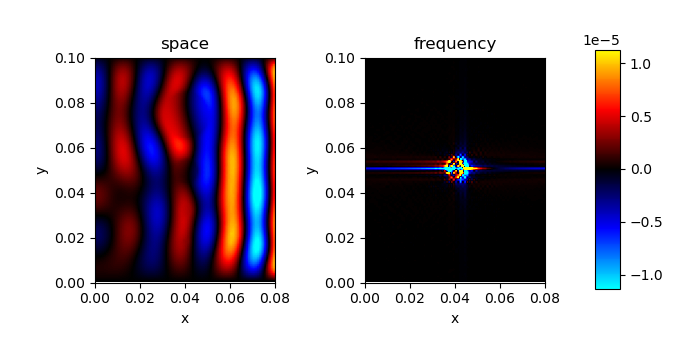

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


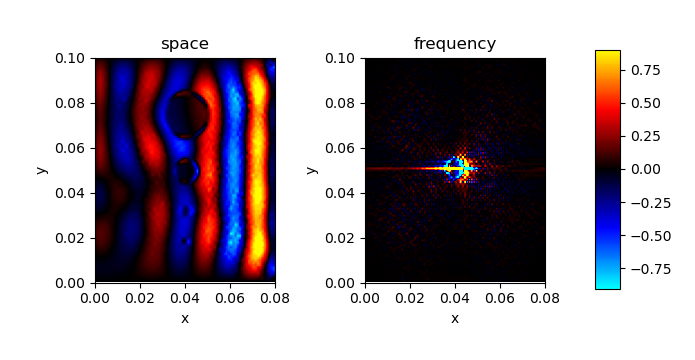

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


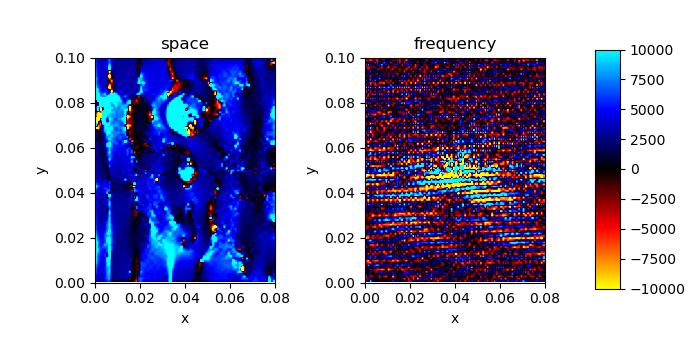

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

<IPython.core.display.Javascript object>


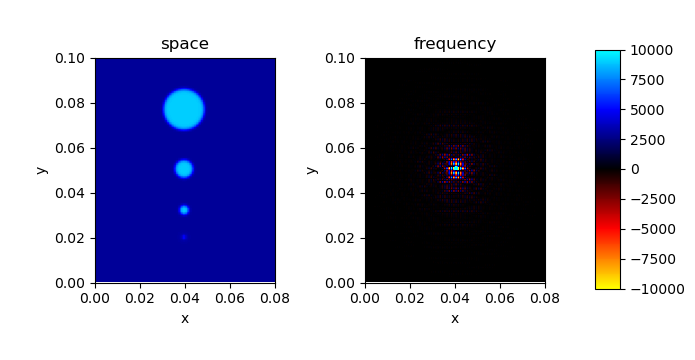

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

In [10]:
%autoreload

# configure color maps
wave_kws = mre_pinn.visual.get_color_kws(data.u)
laplace_kws = mre_pinn.visual.get_color_kws(data.Lu)
elast_kws = mre_pinn.visual.get_color_kws(data.mu)

# display true wave field and elastogram
y = 'y' if 'y' in data.field.spatial_dims else None
hue = None if 'y' in data.field.spatial_dims else 'part'
mre_pinn.visual.XArrayViewer(data.u,  col='domain', y=y, hue=None, ax_width=2, **wave_kws)
mre_pinn.visual.XArrayViewer(data.Lu, col='domain', y=y, hue=None, ax_width=2, **laplace_kws)
mre_pinn.visual.XArrayViewer(data.Mu.mean('frequency'), col='domain', y=y, hue=None, ax_width=2, **elast_kws)
mre_pinn.visual.XArrayViewer(data.mu.mean('frequency'), col='domain', y=y, hue=None, ax_width=2, **elast_kws)

In [11]:
# convert to vector/scalar fields and coordinates
x  = data.u.field.points().astype(np.float32)
u  = data.u.field.values().astype(np.complex64)
mu = data.mu.field.values().astype(np.complex64)

print('x ', type(x), x.shape, x.dtype)
print('u ', type(u), u.shape, u.dtype)
print('mu', type(mu), mu.shape, mu.dtype)

x  <class 'numpy.ndarray'> (8000, 3) float32
u  <class 'numpy.ndarray'> (8000, 2) complex64
mu <class 'numpy.ndarray'> (8000, 1) complex64


In [12]:
%autoreload

# initialize the PDE, geometry, and boundary conditions
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=True)
geom = deepxde.geometry.Hypercube(x.min(axis=0), x.max(axis=0) + 1e-5)
#geom = deepxde.geometry.PointCloud(x)
bc = mre_pinn.fields.VectorFieldBC(x, u)

In [15]:
%autoreload

# define model architecture

net = mre_pinn.model.MREPINN(
    input=x,
    outputs=[u, mu],
    omega0=16,
    n_layers=5,
    n_hidden=128,
    activ_fn='t',
    parallel=True,
    dense=True,
    dtype=torch.float32
)

net

MREPINN(
  (0): InputScaler()
  (1): Parallel(
    (0): FFNN(
      (linear0_tanh): Linear(in_features=3, out_features=128, bias=True)
      (linear1_tanh): Linear(in_features=131, out_features=128, bias=True)
      (linear2_tanh): Linear(in_features=259, out_features=128, bias=True)
      (linear3_tanh): Linear(in_features=387, out_features=128, bias=True)
      (linear4): Linear(in_features=515, out_features=4, bias=True)
    )
    (1): FFNN(
      (linear0_tanh): Linear(in_features=3, out_features=128, bias=True)
      (linear1_tanh): Linear(in_features=131, out_features=128, bias=True)
      (linear2_tanh): Linear(in_features=259, out_features=128, bias=True)
      (linear3_tanh): Linear(in_features=387, out_features=128, bias=True)
      (linear4): Linear(in_features=515, out_features=2, bias=True)
    )
  )
  (2): RealToComplex()
  (3): OutputScaler()
)

In [16]:
model = mre_pinn.training.MREPINNModel(
    net, pde, geom, bc,
    batch_size=80,
    num_domain=128 - 80,
    num_boundary=0,
    train_distribution='pseudo', # NOT using anchors currently!
    anchors=None
)

x [[8.0000000e+01 3.9499987e-02 4.9500085e-02]] [[0.     0.0395 0.0495]]
u [[-9.183170e-08-8.3213047e-07j -2.577481e-09-8.8405780e-09j]] [[6.1520532e-06 3.6243864e-07]]
mu [[3239.4297+502.65485j]] [[1106.456]]
lu [[1.0776840e-03 2.0527215e-05]] [[0.24061526 0.01703473]]


<IPython.core.display.Javascript object>


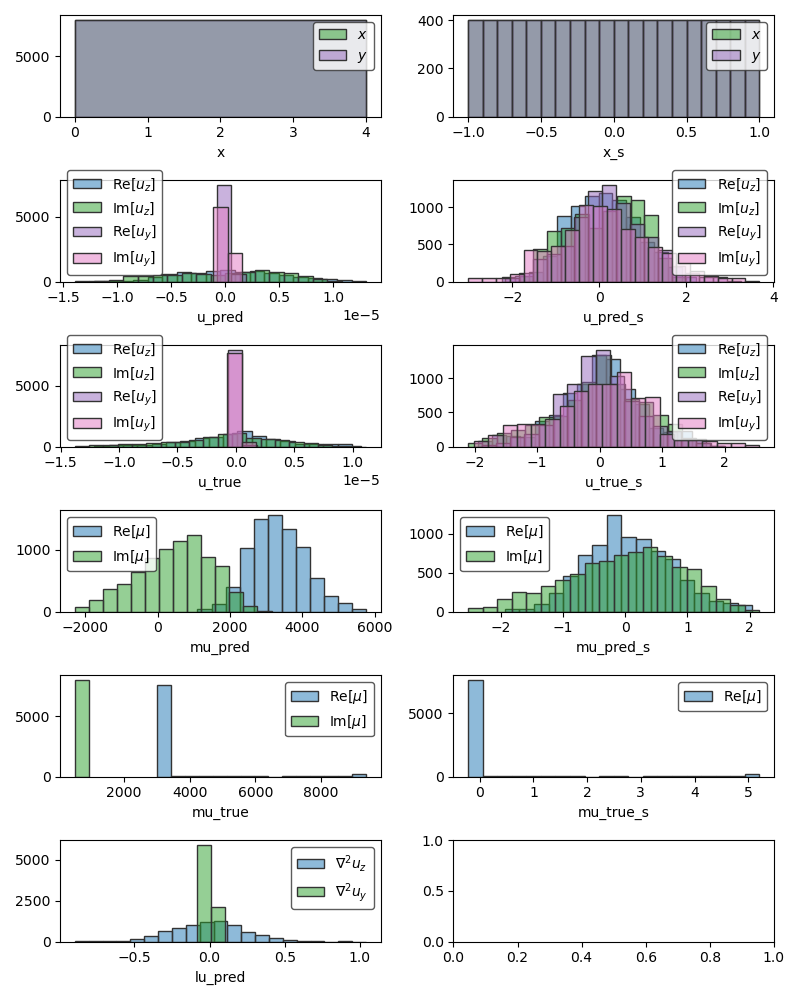

In [17]:
# descriptive statistics

%autoreload

kws = dict(axis=0, keepdims=True)

# standardize input to [-1, 1]
x_loc = x.mean(**kws)
x_scale = (x.max(**kws) - x.min(**kws)) / 2
print('x', x_loc, x_scale)

# avoid division by zero
x_scale[x_scale == 0] = 1
x_s = (x - x_loc) / x_scale

# test forward pass
u_pred, lu_pred, mu_pred, f_trac, f_body = model.predict(x, batch_size=128)
pde_res = f_trac + f_body

u_pred = u_pred.detach().cpu().numpy()
lu_pred = lu_pred.detach().cpu().numpy()
mu_pred = mu_pred.detach().cpu().numpy()

# normalize outputs via mean and std
u_loc = u.mean(**kws)
u_scale = u.std(**kws)
print('u', u_loc, u_scale)

u_s = (u - u_loc) / u_scale
u_pred_s = (u_pred - u_loc) / u_scale

mu_loc = mu.mean(**kws)
mu_scale = mu.std(**kws)
print('mu', mu_loc, mu_scale)

mu_s = (mu - mu_loc) / mu_scale
mu_pred_s = (mu_pred - mu_loc) / mu_scale

# compute laplacian statistics
lu_loc = lu_pred.mean(**kws)
lu_scale = lu_pred.std(**kws)
print('lu', lu_loc, lu_scale)

# display input and output distributions

def hex_to_rgb(h):
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

def plot_hist(ax, a, xlabel, hue=None):
    if np.iscomplexobj(a):
        a = mre_pinn.utils.as_real(a)
    bin_width = (a.max() - a.min()) / 20
    for a, hue in zip(a.T, hue):
        bins = np.arange(a.min(), a.max() + bin_width, bin_width)
        color = next(ax._get_lines.prop_cycler)["color"]
        ax.hist(a, bins=bins, label=hue, edgecolor='0.2', fc=color + '80')
    ax.set_xlabel(xlabel)
    ax.legend(frameon=True, edgecolor='0.2')

fig, axes = plt.subplots(6, 2, figsize=(8, 10))

ndim = len(data.u.field.spatial_dims)
x_hues = ['$\omega$', '$x$', '$y$', '$z$'][:ndim+1]
plot_hist(axes[0,0], x,   hue=x_hues, xlabel='x')
plot_hist(axes[0,1], x_s, hue=x_hues, xlabel='x_s')

u_hues = ['$u_z$', '$u_y$', '$u_x$'][:ndim]
u_hues = [p.format(h) for h in u_hues for p in ['Re[{}]', 'Im[{}]']]
plot_hist(axes[1,0], u_pred,   hue=u_hues, xlabel='u_pred')
plot_hist(axes[1,1], u_pred_s, hue=u_hues, xlabel='u_pred_s')

plot_hist(axes[2,0], u,   hue=u_hues, xlabel='u_true')
plot_hist(axes[2,1], u_s, hue=u_hues, xlabel='u_true_s')

mu_hues = ['Re[$\mu$]', 'Im[$\mu$]']
plot_hist(axes[3,0], mu_pred,   hue=mu_hues, xlabel='mu_pred')
plot_hist(axes[3,1], mu_pred_s, hue=mu_hues, xlabel='mu_pred_s')

plot_hist(axes[4,0], mu,   hue=mu_hues, xlabel='mu_true')
plot_hist(axes[4,1], mu_s, hue=mu_hues, xlabel='mu_true_s')

lu_hues = ['$\\nabla^2 u_z$', '$\\nabla^2 u_y$', '$\nabla^2 u_x$'][:ndim]
#lu_hues = [p.format(h) for h in lu_hues for p in ['Re[{}]', 'Im[{}]']]
plot_hist(axes[5,0], lu_pred, hue=lu_hues, xlabel='lu_pred')

fig.tight_layout()

Compiling model...
'compile' took 0.000438 s

Training model...



<IPython.core.display.Javascript object>


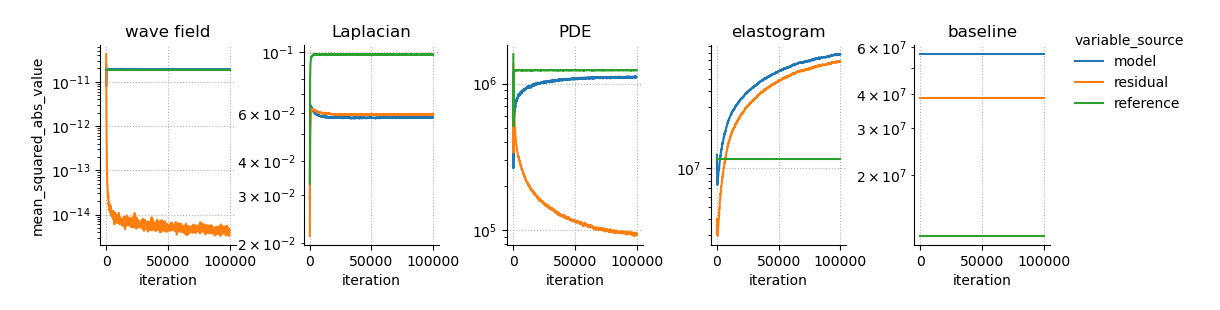

<IPython.core.display.Javascript object>


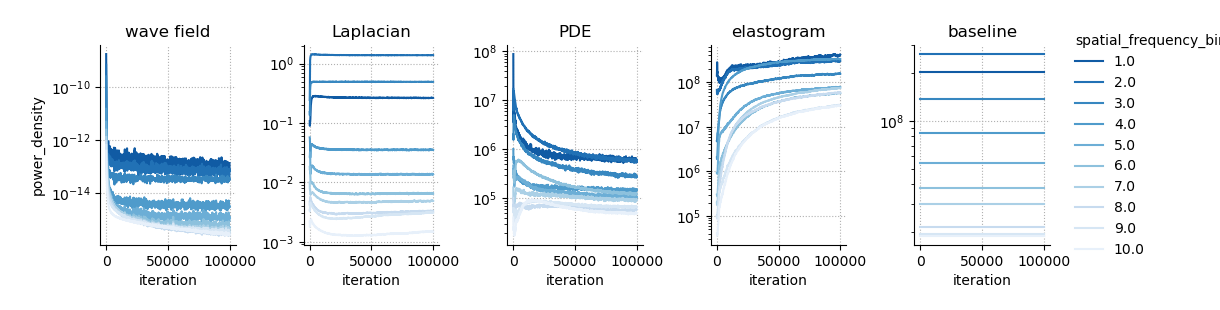

<IPython.core.display.Javascript object>


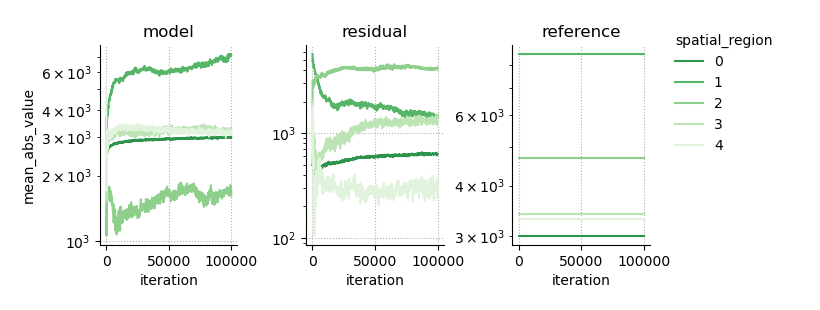

<IPython.core.display.Javascript object>


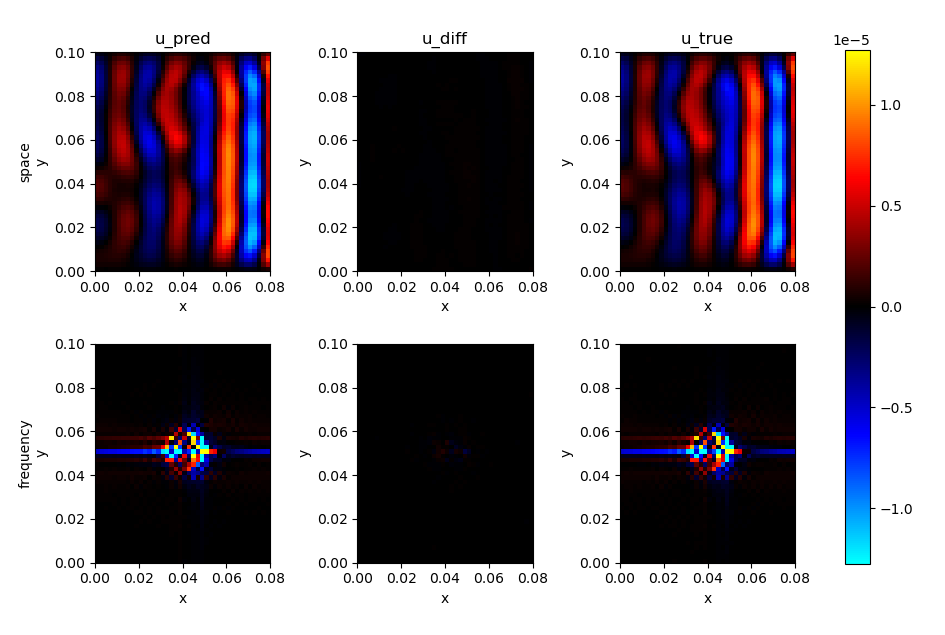

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


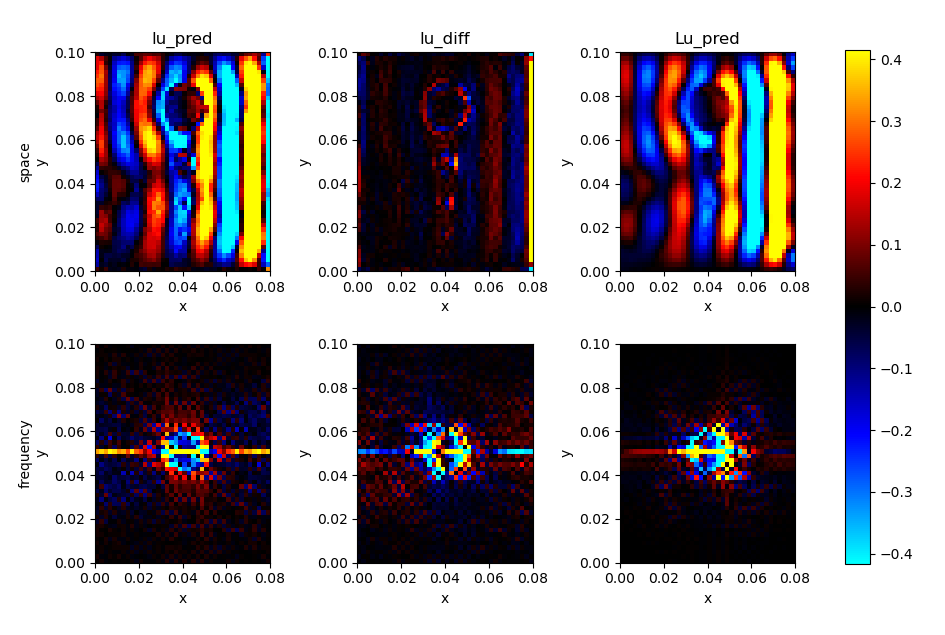

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


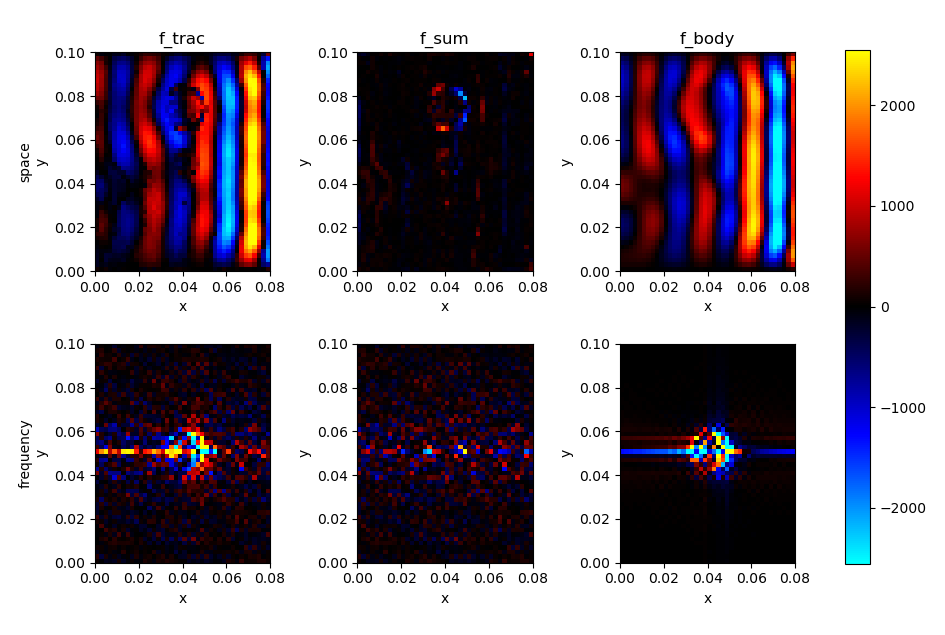

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


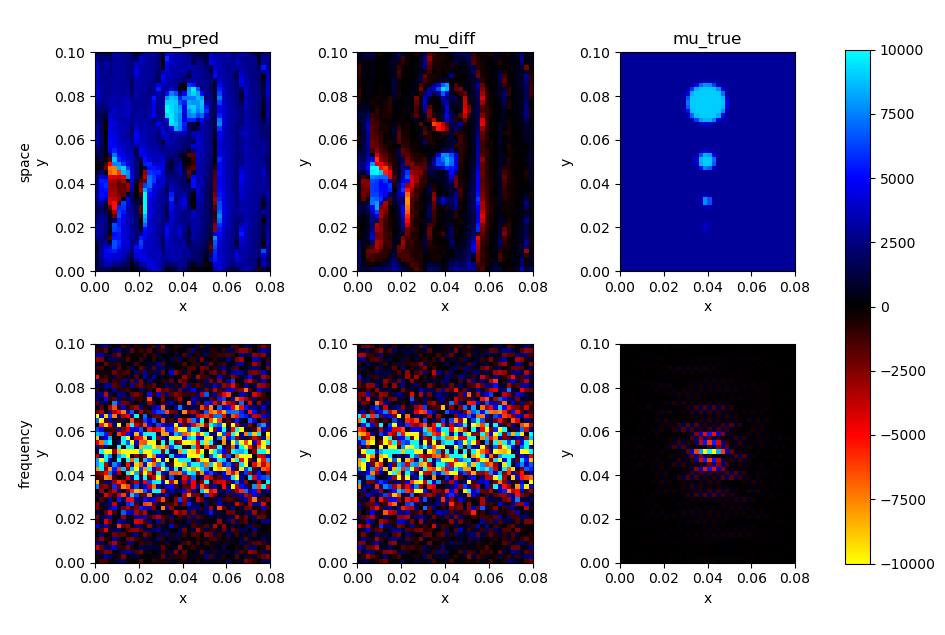

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

<IPython.core.display.Javascript object>


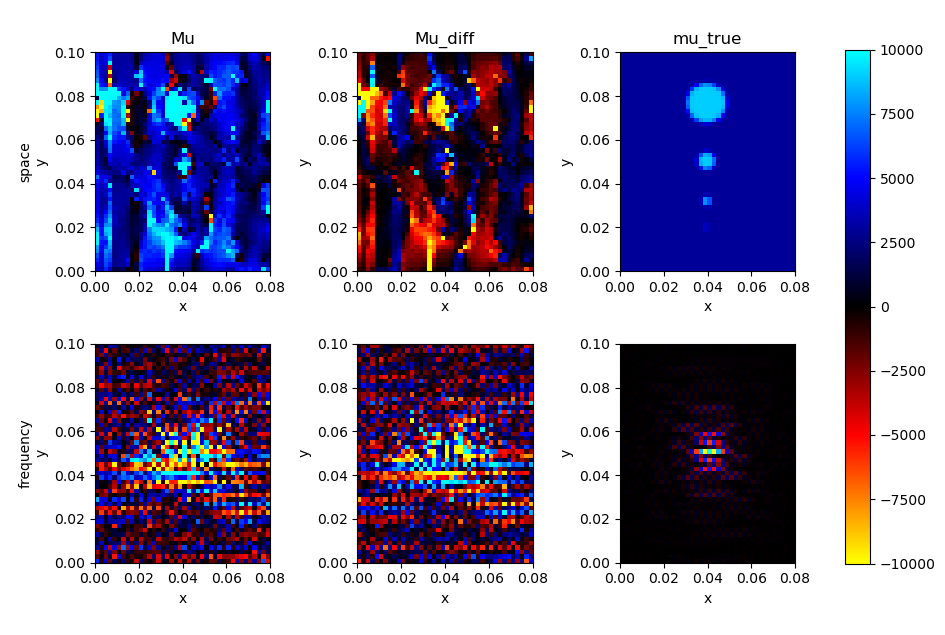

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

Time spent testing: 63.89%
Time spent testing: 58.26%
Time spent testing: 55.90%
Time spent testing: 54.47%
Time spent testing: 54.02%
Time spent testing: 53.39%
Time spent testing: 52.92%
Time spent testing: 52.58%
Time spent testing: 52.31%
Time spent testing: 52.07%
Time spent testing: 51.89%
Time spent testing: 51.76%
Time spent testing: 51.64%
Time spent testing: 51.53%
Time spent testing: 51.62%
Time spent testing: 51.53%
Time spent testing: 51.46%
Time spent testing: 51.39%
Time spent testing: 51.34%
Time spent testing: 51.29%
Time spent testing: 51.26%
Time spent testing: 51.23%
Time spent testing: 51.21%
Time spent testing: 51.30%
Time spent testing: 51.28%
Time spent testing: 51.26%
Time spent testing: 51.25%
Time spent testing: 51.24%
Time spent testing: 51.23%
Time spent testing: 51.22%
Time spent testing: 51.21%
Time spent testing: 51.19%
Time spent testing: 51.27%
Time spent testing: 51.27%
Time spent testing: 51.19%
Time spent testing: 51.12%
Time spent testing: 51.05%
T

Time spent testing: 56.09%
Time spent testing: 56.12%
Time spent testing: 56.14%
Time spent testing: 56.15%
Time spent testing: 56.17%
Time spent testing: 56.19%
Time spent testing: 56.20%
Time spent testing: 56.22%
Time spent testing: 56.24%
Time spent testing: 56.26%
Time spent testing: 56.27%
Time spent testing: 56.29%
Time spent testing: 56.31%
Time spent testing: 56.33%
Time spent testing: 56.36%
Time spent testing: 56.38%
Time spent testing: 56.41%
Time spent testing: 56.43%
Time spent testing: 56.46%
Time spent testing: 56.48%
Time spent testing: 56.51%
Time spent testing: 56.53%
Time spent testing: 56.56%
Time spent testing: 56.58%
Time spent testing: 56.61%
Time spent testing: 56.63%
Time spent testing: 56.66%
Time spent testing: 56.67%
Time spent testing: 56.70%
Time spent testing: 56.71%
Time spent testing: 56.73%
Time spent testing: 56.74%
Time spent testing: 56.76%
Time spent testing: 56.77%
Time spent testing: 56.79%
Time spent testing: 56.81%
Time spent testing: 56.83%
T

Time spent testing: 61.88%
Time spent testing: 61.90%
Time spent testing: 61.92%
Time spent testing: 61.94%
Time spent testing: 61.96%
Time spent testing: 61.98%
Time spent testing: 62.00%
Time spent testing: 62.02%
Time spent testing: 62.04%
Time spent testing: 62.06%
Time spent testing: 62.08%
Time spent testing: 62.10%
Time spent testing: 62.12%
Time spent testing: 62.14%
Time spent testing: 62.16%
Time spent testing: 62.18%
Time spent testing: 62.20%
Time spent testing: 62.21%
Time spent testing: 62.24%
Time spent testing: 62.25%
Time spent testing: 62.28%
Time spent testing: 62.29%
Time spent testing: 62.31%
Time spent testing: 62.33%
Time spent testing: 62.35%
Time spent testing: 62.37%
Time spent testing: 62.39%
Time spent testing: 62.41%
Time spent testing: 62.43%
Time spent testing: 62.45%
Time spent testing: 62.47%
Time spent testing: 62.49%
Time spent testing: 62.51%
Time spent testing: 62.53%
Time spent testing: 62.55%
Time spent testing: 62.56%
Time spent testing: 62.58%
T

Time spent testing: 66.84%
Time spent testing: 66.85%
Time spent testing: 66.87%
Time spent testing: 66.88%
Time spent testing: 66.90%
Time spent testing: 66.92%
Time spent testing: 66.93%
Time spent testing: 66.95%
Time spent testing: 66.96%
Time spent testing: 66.98%
Time spent testing: 66.99%
Time spent testing: 67.01%
Time spent testing: 67.03%
Time spent testing: 67.04%
Time spent testing: 67.06%
Time spent testing: 67.07%
Time spent testing: 67.09%
Time spent testing: 67.10%
Time spent testing: 67.12%
Time spent testing: 67.13%
Time spent testing: 67.15%
Time spent testing: 67.17%
Time spent testing: 67.18%
Time spent testing: 67.20%
Time spent testing: 67.21%
Time spent testing: 67.23%
Time spent testing: 67.24%
Time spent testing: 67.26%
Time spent testing: 67.28%
Time spent testing: 67.29%
Time spent testing: 67.31%
Time spent testing: 67.32%
Time spent testing: 67.34%
Time spent testing: 67.35%
Time spent testing: 67.37%
Time spent testing: 67.38%
Time spent testing: 67.40%
T

In [18]:
%autoreload

model.compile(
    optimizer='adam',
    lr=1e-4,
    loss_weights=[1e-8, 1],
    loss=mre_pinn.training.normalized_l2_loss_fn(u)
)
deepxde.display.training_display = mre_pinn.training.SummaryDisplay()
callbacks = [
    mre_pinn.training.TestEvaluation(test_data, batch_size=128, test_every=100, save_every=1000, interact=True),
    mre_pinn.training.PDEResampler(period=1),
]

try:
    model.train(100000, display_every=10, callbacks=callbacks)
except KeyboardInterrupt as e:
    print('Interrupt', file=sys.stderr)

<IPython.core.display.Javascript object>


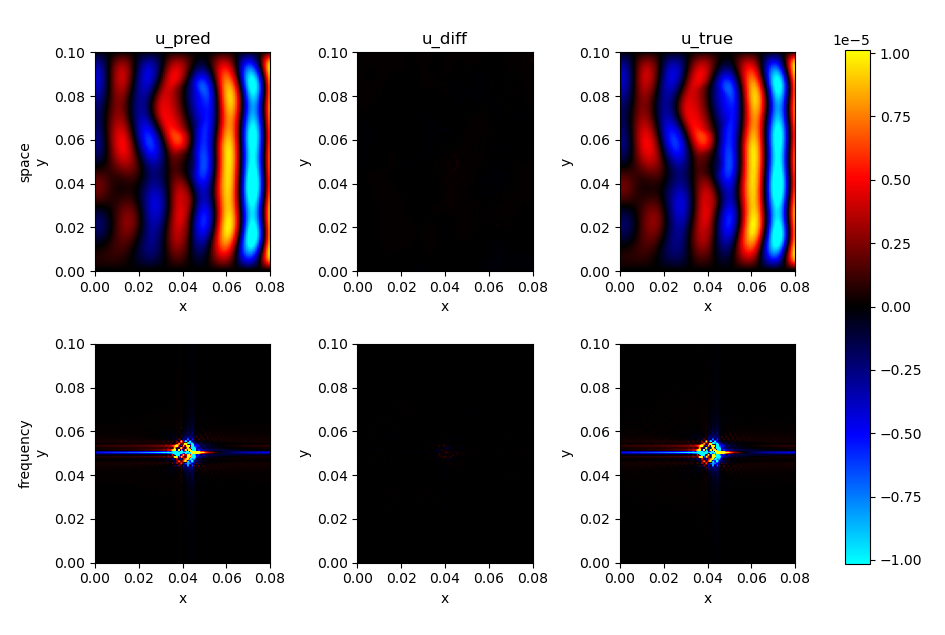

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


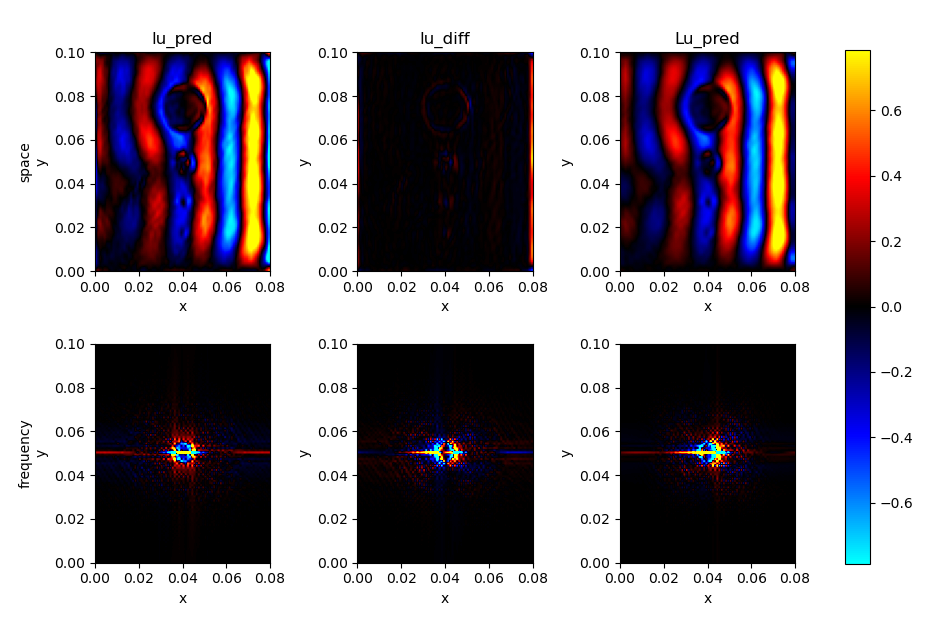

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


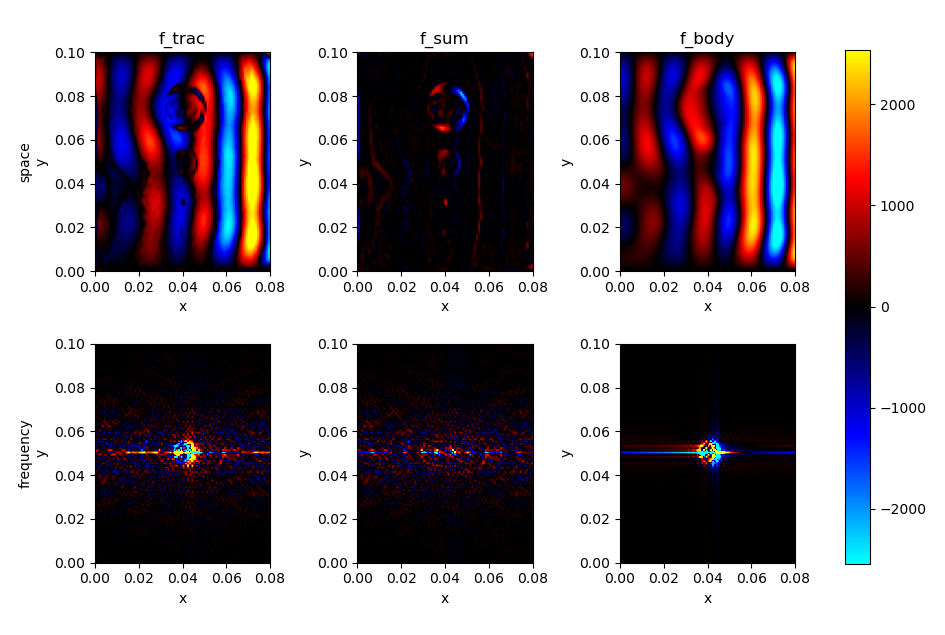

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


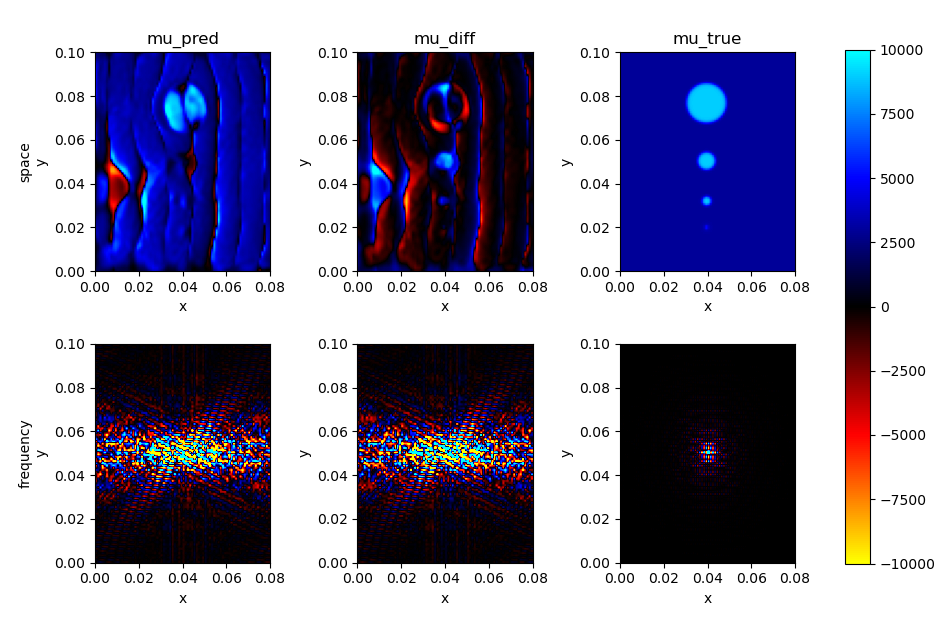

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

<IPython.core.display.Javascript object>


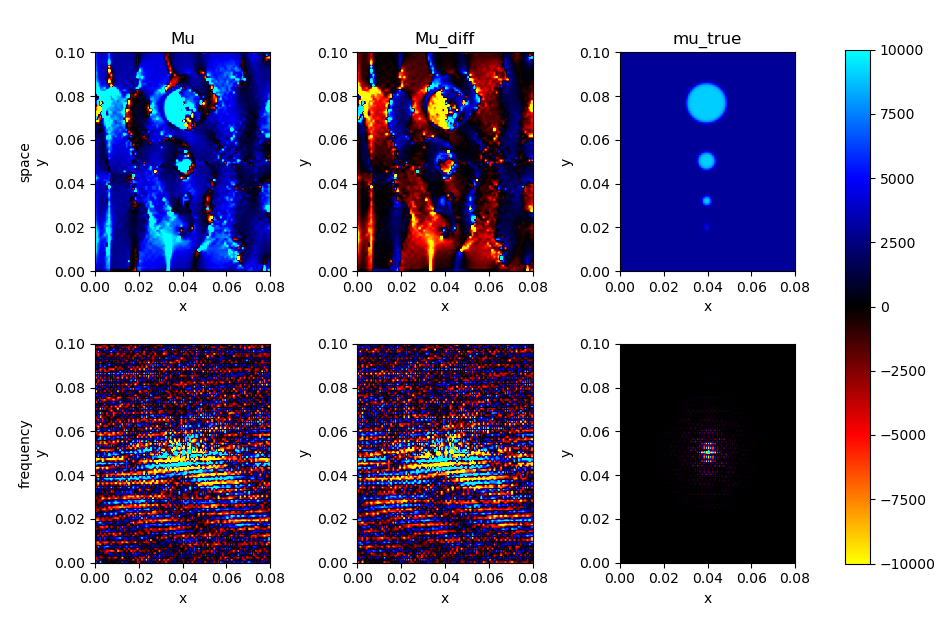

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Output…

In [19]:
%autoreload
test_eval = mre_pinn.training.TestEvaluation(data, batch_size=128, plot=False, view=True, interact=True)
test_eval.model = model
test_eval.test_evaluate(data)